# EDA

## Import

In [3]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")


In [4]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Dataset Paths

In [5]:
TRAIN_DIR = "../dataset/train"
VAL_DIR   = "../dataset/val"
TEST_DIR  = "../dataset/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [6]:
print("Current working directory:", os.getcwd())
print("Train exists:", os.path.exists(TRAIN_DIR))
print("Val exists:", os.path.exists(VAL_DIR))
print("Test exists:", os.path.exists(TEST_DIR))


Current working directory: c:\Fish_Classification\notebooks
Train exists: True
Val exists: True
Test exists: True


## Load Dataset with ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


## Load Train / Val / Test

In [8]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [10]:
print("Number of classes:", train_gen.num_classes)
print("Class indices:\n", train_gen.class_indices)


Number of classes: 11
Class indices:
 {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


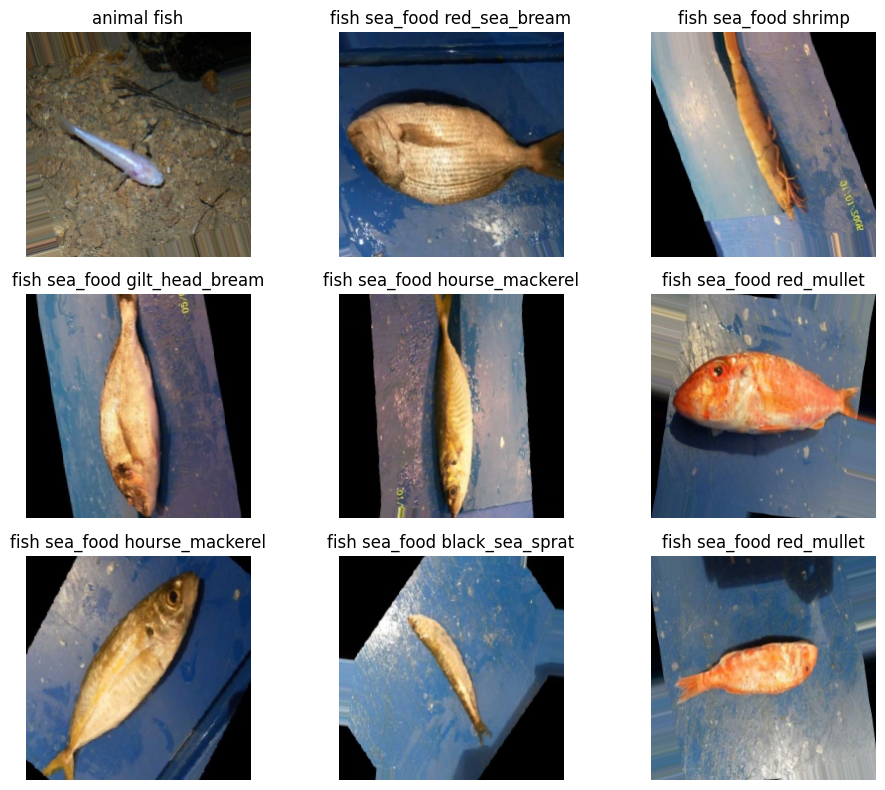

In [11]:
images, labels = next(train_gen)

plt.figure(figsize=(10, 8))
class_names = list(train_gen.class_indices.keys())

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

plt.tight_layout()
plt.show()


# ML Training

## Import Model Layers

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


## CNN Model

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(11, activation="softmax")   # 11 classes
])


In [14]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,499 (84.87 MB)

 Trainable params: 22,247,499 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


In [16]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.4352 - loss: 1.6259 - val_accuracy: 0.6969 - val_loss: 0.9464
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.6529 - loss: 0.9652 - val_accuracy: 0.8040 - val_loss: 0.6270
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.7410 - loss: 0.7154 - val_accuracy: 0.8498 - val_loss: 0.4694
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8227 - loss: 0.5227 - val_accuracy: 0.8755 - val_loss: 0.3701
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8414 - loss: 0.4685 - val_accuracy: 0.8672 - val_loss: 0.4314
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8625 - loss: 0.4006 - val_accuracy: 0.9542 - val_loss: 0.1755
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.8946 - loss: 0.3243 - val_accuracy: 0.9579 - val_loss: 0.1620
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9060 - loss: 0.2904 - val_accu

## Accuracy and Loss

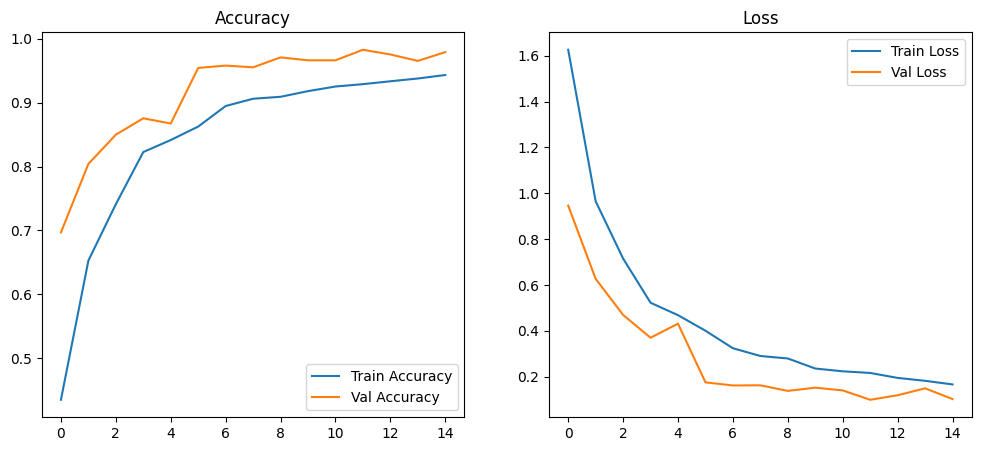

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [18]:
model.save("../models/cnn_baseline.h5")


In [19]:
model.save("../models/cnn_baseline.keras")


## Evaluate on the Test Set

In [20]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 644ms/step - accuracy: 0.9827 - loss: 0.0776
Test Accuracy: 0.9827
Test Loss: 0.0776


## Generate Prediction

In [21]:
import numpy as np

y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step


## Classification Report

In [22]:
from sklearn.metrics import classification_report

class_names = list(train_gen.class_indices.keys())

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.98      1.00      0.99       298
   fish sea_food gilt_head_bream       0.97      0.97      0.97       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       0.98      0.94      0.96       273
          fish sea_food sea_bass       0.96      0.99      0.98       327
            fish sea_food shrimp       1.00      0.99      0.99       289
fish sea_food striped_red_mullet       0.98      0.99      0.99       293
             fish sea_food trout       0.99      1.00      0.99       292

                        accuracy                           0.98      3187
                       macro avg    

## Confusion Matrix

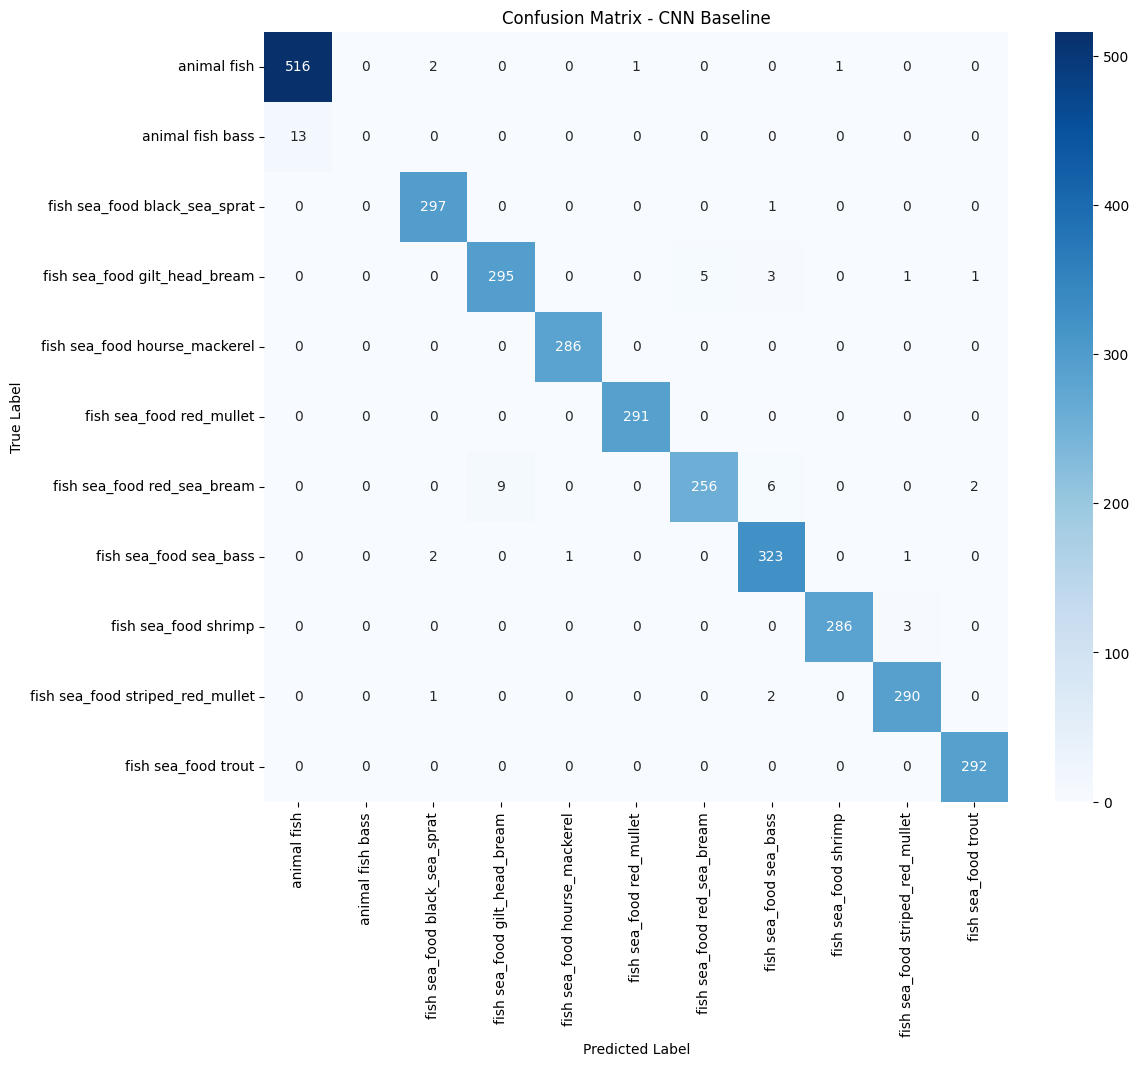

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN Baseline")
plt.show()


# Transfer Learning 

## Import

In [27]:
import warnings

warnings.filterwarnings("ignore")
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


## Load Pretrained Base Model

In [28]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model (VERY IMPORTANT)
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Build Transfer Learning Model

In [30]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(11, activation="softmax")(x)

tl_model = Model(inputs=base_model.input, outputs=output)


## Compile Transfer Learning Model

In [31]:
tl_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

tl_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,747 (9.88 MB)

 Trainable params: 330,763 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Early Stopping

In [32]:
early_stop_tl = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


## Train Transfer Learning Model

In [33]:
history_tl = tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop_tl]
)


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.8400 - loss: 0.5175 - val_accuracy: 0.9643 - val_loss: 0.1217
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9544 - loss: 0.1453 - val_accuracy: 0.9744 - val_loss: 0.0688
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9598 - loss: 0.1124 - val_accuracy: 0.9844 - val_loss: 0.0487
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9677 - loss: 0.0917 - val_accuracy: 0.9799 - val_loss: 0.0512
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9786 - loss: 0.0642 - val_accuracy: 0.9872 - val_loss: 0.0333
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9796 - loss: 0.0602 - val_accuracy: 0.9853 - val_loss: 0.0402
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9812 - loss: 0.0605 - val_accuracy: 0.9817 - val_loss: 0.0422
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 194s 995ms/step - accuracy: 0.9815 - loss: 0.0576 - val_a

## Plot Accuracy & Loss

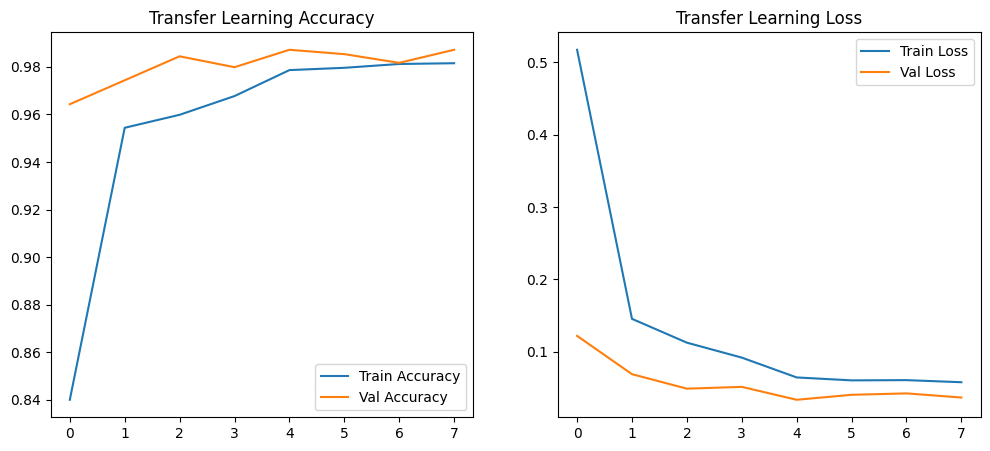

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tl.history["accuracy"], label="Train Accuracy")
plt.plot(history_tl.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Transfer Learning Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_tl.history["loss"], label="Train Loss")
plt.plot(history_tl.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Transfer Learning Loss")

plt.show()


## Evaluate on Test Data

In [35]:
test_loss_tl, test_acc_tl = tl_model.evaluate(test_gen)

print(f"Transfer Learning Test Accuracy: {test_acc_tl:.4f}")
print(f"Transfer Learning Test Loss: {test_loss_tl:.4f}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9940 - loss: 0.0228
Transfer Learning Test Accuracy: 0.9940
Transfer Learning Test Loss: 0.0228


## Predictions

In [36]:
import numpy as np

y_pred_prob_tl = tl_model.predict(test_gen)
y_pred_tl = np.argmax(y_pred_prob_tl, axis=1)
y_true = test_gen.classes


100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 872ms/step


## Classification Report

In [38]:
from sklearn.metrics import classification_report

class_names = list(train_gen.class_indices.keys())

print(classification_report(
    y_true,
    y_pred_tl,
    target_names=class_names
))


                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      0.99       520
                animal fish bass       1.00      0.46      0.63        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      0.97      0.99       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      0.99      1.00       291
     fish sea_food red_sea_bream       0.97      1.00      0.99       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      1.00      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           0.99      3187
                       macro avg    

## Confusion Matrix

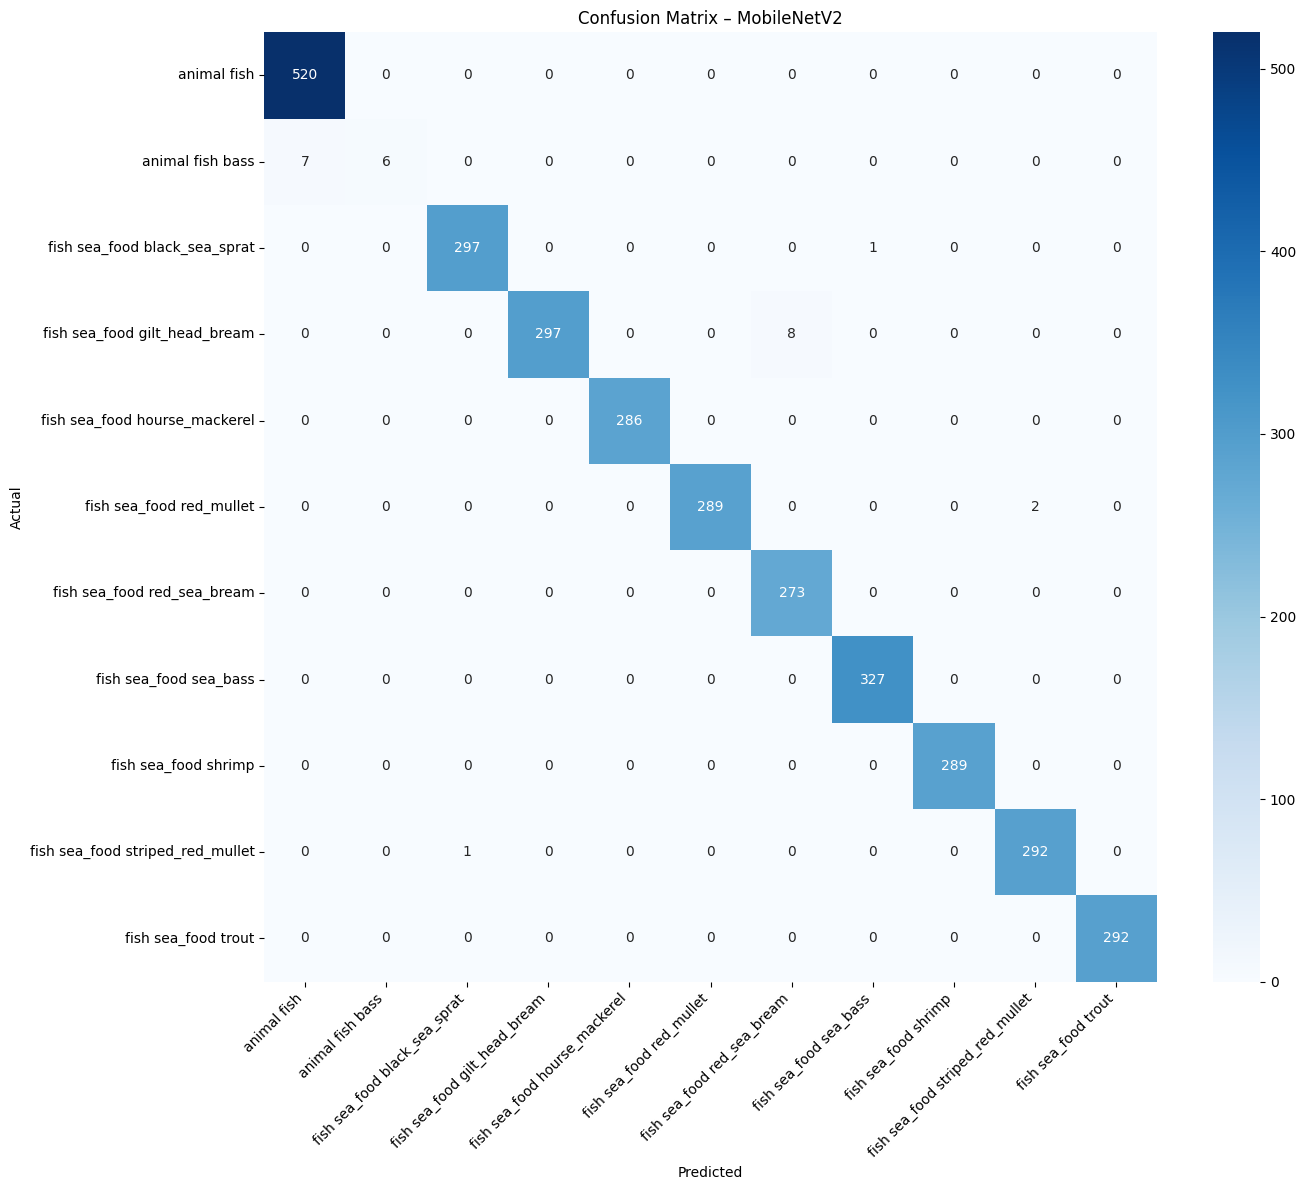

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_tl = confusion_matrix(y_true, y_pred_tl)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_tl,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Confusion Matrix – MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [40]:
tl_model.save("../models/mobilenet_fish.h5")
tl_model.save("../models/mobilenet_fish.keras")
print("✅ MobileNetV2 model saved successfully")


✅ MobileNetV2 model saved successfully
